<h3>Name: Nguyen Van Hau <br> <br>
Student ID: 2111167 </h3>

# NLP Assignment: Sentiment Analysis - VLSP Dataset

## 1 Set up environment

### 1.1 For Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

NotImplementedError: Mounting drive is unsupported in this environment. Use PyDrive instead. See examples at https://colab.research.google.com/notebooks/io.ipynb#scrollTo=7taylj9wpsA2.

### 1.2 For Kaggle

In [1]:
#Setup Gdrive file download extention 
!pip install gdown

Download train set/test set/word2vec model:

In [2]:
!gdown --id 1FiQSFJSiRBO_J4rYfZ94peoMv3x-Dup3 # vlsp_sentiment_train.csv
!gdown --id 1uruxz2CcconYmJNgGr_qL6t5nUwfkaST # vlsp_sentiment_test.csv
!gdown --id 1uCGz-aM9NgrF1d2hLcXeAkjoN9YqNO8j # vi-model-CBOW.bin

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1FiQSFJSiRBO_J4rYfZ94peoMv3x-Dup3
To: /kaggle/working/vlsp_sentiment_train.csv
100%|████████████████████████████████████████| 858k/858k [00:00<00:00, 68.2MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1uruxz2CcconYmJNgGr_qL6t5nUwfkaST
To: /kaggle/working/vlsp_sentiment_test.csv
100%|████████████████████████████████████████| 159k/159k [00:00<00:00, 88.9MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be

### 1.3 Download neccessary libraries

In [3]:
!pip install underthesea
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 82.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 48.2 MB/s eta 0:00:00


**This is the solution for the tensorflow conflict on numpy 1.26.4, can skip if the below importing libraries are not got any error (don't run this at first)**

In [ ]:
# # 1. Uninstall everything (including hidden dependencies)
# !pip uninstall numpy tensorflow -y
# !pip install --upgrade --force-reinstall numpy==1.26.4

# # 2. Install TensorFlow 2.15 (latest stable version compatible with NumPy 1.26.4)
# !pip install tensorflow==2.15.0

# # 3. Restart the runtime (MUST DO THIS)
# import os
# os.kill(os.getpid(), 9)  # Force-restart

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires tensorflow>=2.2.0, which is not installed.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 26.8 MB/s eta 0:00:00
   ━━━━━

### 1.4 Import libraries

In [4]:
import numpy as np
import tensorflow as tf
import pandas as pd
from string import digits
from collections import Counter
from underthesea import word_tokenize
from gensim.models.word2vec import Word2Vec
from keras.utils import to_categorical
%matplotlib inline

### 1.5 Mount folder from drive to colab (skip if running on Kaggle or local environment)

In [4]:
!cp -r "/content/drive/MyDrive/HCMUT_POSTGRAD_242/Sentiment_Analysis" /content

In [5]:
%cd "/content/Sentiment_Analysis"

/content/Sentiment_Analysis


## 2 Implementation

### 2.1 Read the VLSP dataset

In [5]:
data_train = pd.read_csv("vlsp_sentiment_train.csv", sep='\t')
data_train.columns = ['Class', 'Data']
data_test = pd.read_csv("vlsp_sentiment_test.csv", sep='\t')
data_test.columns = ['Class', 'Data']

In [6]:
print(data_train.shape)
print(data_test.shape)

(5100, 2)
(1050, 2)


### 2.2 Data Preprocessing

In [7]:
labels = data_train.iloc[:, 0].values
reviews = data_train.iloc[:, 1].values

In [8]:
encoded_labels = []

for label in labels:
    if label == -1:
        encoded_labels.append([1,0,0])
    elif label == 0:
        encoded_labels.append([0,1,0])
    else:
        encoded_labels.append([0,0,1])

encoded_labels = np.array(encoded_labels)

In [9]:
reviews_processed = []
for review in reviews:
    review_cool_one = ''.join([char for char in review if char not in digits])
    reviews_processed.append(review_cool_one)

In [10]:
# Use Underthesea for Vietnamese word tokenizer
word_reviews = []
for review in reviews_processed:
    review = word_tokenize(review.lower())
    word_reviews.append(review)

In [11]:
EMBEDDING_DIM = 400 # how big is each word vector
MAX_VOCAB_SIZE = 10000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH = 300 # max number of words in a comment to use

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [13]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(word_reviews)
sequences_train = tokenizer.texts_to_sequences(word_reviews)
word_index = tokenizer.word_index

In [14]:
data = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
labels = encoded_labels

In [15]:
print('Shape of X train and X validation tensor:', data.shape)
print('Shape of label train and validation tensor:', labels.shape)

Shape of X train and X validation tensor: (5100, 300)
Shape of label train and validation tensor: (5100, 3)


In [17]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('vi-model-CBOW.bin', binary=True)

vocabulary_size=min(len(word_index)+1,MAX_VOCAB_SIZE)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
print("vocab size", vocabulary_size)
for word, i in word_index.items():
    if i>=MAX_VOCAB_SIZE:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

vocab size 10000


### LSTM + CNN

In [19]:
from keras.models import Model
from keras.layers import *
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import AdamW
from keras.models import Model
from keras import regularizers
sequence_length = data.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.3

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

reshape = Reshape((sequence_length,EMBEDDING_DIM))(embedding)

conv_0 = Conv1D(num_filters, (filter_sizes[0], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv1D(num_filters, (filter_sizes[1], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_2 = Conv1D(num_filters, (filter_sizes[2], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

conv_0 = MaxPooling1D(sequence_length - filter_sizes[0] + 1)(conv_0)
conv_1 = MaxPooling1D(sequence_length - filter_sizes[1] + 1)(conv_1)
conv_2 = MaxPooling1D(sequence_length - filter_sizes[2] + 1)(conv_2)

# Reshape output to match RNN dimension
conv_0 = Reshape((-1, num_filters))(conv_0)
conv_1 = Reshape((-1, num_filters))(conv_1)
conv_2 = Reshape((-1, num_filters))(conv_2)

concat = concatenate([conv_0, conv_1, conv_2])
concat = Dropout(drop)(concat)

lstm_0 = LSTM(256)(concat)
dropout = Dropout(drop)(lstm_0)

output = Dense(units=3, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(dropout)

# this creates a model that includes
model = Model(inputs, output)


adamW = AdamW(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy', optimizer=adamW, metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 300)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 300, 400)       │      4,000,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 300, 400)       │              0 │ embedding_1[1][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 300, 100)       │        120,100 │ reshape_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 300, 100)       │        160,100 │ reshape_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 300, 100)       │        200,100 │ reshape_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 1, 100)         │              0 │ conv1d_3[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_4           │ (None, 1, 100)         │              0 │ conv1d_4[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_5           │ (None, 1, 100)         │              0 │ conv1d_5[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_5 (Reshape)       │ (None, 1, 100)         │              0 │ max_pooling1d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_6 (Reshape)       │ (None, 1, 100)         │              0 │ max_pooling1d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_7 (Reshape)       │ (None, 1, 100)         │              0 │ max_pooling1d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 1, 300)         │              0 │ reshape_5[0][0],       │
│ (Concatenate)             │                        │                │ reshape_6[0][0],       │
│                           │                        │                │ reshape_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 1, 300)         │              0 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 256)            │        570,368 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 256)            │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)      

 Total params: 5,051,439 (19.27 MB)

 Trainable params: 5,051,439 (19.27 MB)

 Non-trainable params: 0 (0.00 B)

In [98]:
### IF YOU HAVE MODEL WEIGHT AND WANNA LOAD IT
model.load_weights("model.h5")

In [21]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=4, verbose=1)
callbacks_list = [early_stopping]

model.fit(data, labels, validation_split=0.1,
          epochs=50, batch_size=256, callbacks=callbacks_list, shuffle=True)

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.7976 - loss: 1.8863 - val_accuracy: 0.2804 - val_loss: 2.6481
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.8221 - loss: 1.7836 - val_accuracy: 0.4608 - val_loss: 2.3180
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.8390 - loss: 1.6996 - val_accuracy: 0.4529 - val_loss: 2.2882
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.8655 - loss: 1.5985 - val_accuracy: 0.4098 - val_loss: 2.2827
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.8807 - loss: 1.5151 - val_accuracy: 0.3980 - val_loss: 2.3112
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.8900 - loss: 1.4507 - val_accuracy: 0.4529 - val_loss: 2.2163
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.8911 - loss: 1.3972 - val_accuracy: 0.2667 - val_loss: 2.5539
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9057 - loss: 1.3260 - val_accuracy: 0.

In [22]:
labels_test = data_test.iloc[:, 0].values
reviews_test = data_test.iloc[:, 1].values

In [23]:
encoded_labels_test = []

for label_test in labels_test:
    if label_test == -1:
        encoded_labels_test.append([1,0,0])
    elif label_test == 0:
        encoded_labels_test.append([0,1,0])
    else:
        encoded_labels_test.append([0,0,1])

encoded_labels_test = np.array(encoded_labels_test)

In [24]:
reviews_processed_test = []
for review_test in reviews_test:
    review_cool_one = ''.join([char for char in review_test if char not in digits])
    reviews_processed_test.append(review_cool_one)

In [25]:
# Use underthesea for Vietnamese word tokenizer
word_reviews_test = []
for review_test in reviews_processed_test:
    review_test = word_tokenize(review_test.lower())
    word_reviews_test.append(review_test)

In [26]:
sequences_test = tokenizer.texts_to_sequences(word_reviews_test)
data_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
labels_test = encoded_labels_test

In [27]:
print('Shape of X train and X validation tensor:',data_test.shape)
print('Shape of label train and validation tensor:', labels_test.shape)

Shape of X train and X validation tensor: (1050, 300)
Shape of label train and validation tensor: (1050, 3)


In [28]:
score = model.evaluate(data_test, labels_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6003 - loss: 1.8269


In [29]:
print("%s: %.2f" % (model.metrics_names[0], score[0]))
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

loss: 1.79
compile_metrics: 61.52%


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
True labels seem to be one-hot encoded. Converting to single dimension.

Accuracy: 0.6152

--- Averaged Metrics ---
Precision (Macro): 0.6128
Recall (Macro):    0.6152
F1-score (Macro):  0.6115
--------------------
Precision (Weighted): 0.6128
Recall (Weighted):    0.6152
F1-score (Weighted):  0.6115
--------------------

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.59      0.58      0.59       350
           1       0.60      0.51      0.55       350
           2       0.64      0.75      0.69       350

    accuracy                           0.62      1050
   macro avg       0.61      0.62      0.61      1050
weighted avg       0.61      0.62      0.61      1050


--- Confusion Matrix ---
[[203  76  71]
 [ 96 180  74]
 [ 44  43 263]]


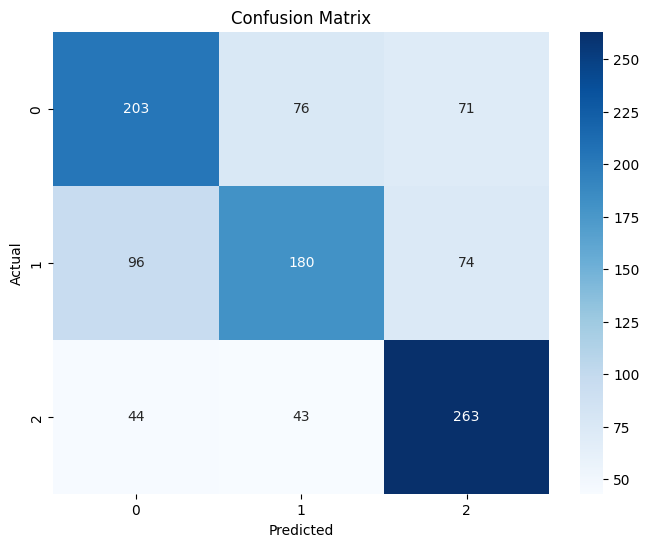

In [30]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns 
import matplotlib.pyplot as plt 

# 1. Get raw probability predictions from the model
y_pred_probabilities = model.predict(data_test)

# 2. Convert probabilities to class predictions (index of the highest probability)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# 3. Get true labels in the same format (if they are one-hot encoded)
# Check if labels_test is one-hot encoded (e.g., shape like [num_samples, 3])
if labels_test.ndim > 1 and labels_test.shape[1] > 1:
    print("True labels seem to be one-hot encoded. Converting to single dimension.")
    y_true = np.argmax(labels_test, axis=1)
else:
    # Assume labels_test is already a 1D array of class indices
    print("True labels seem to be single dimension.")
    y_true = labels_test # Use directly if already in the format [0, 1, 2, ...]

# --- Calculate and Print Metrics ---

# 4. Accuracy (should match model.evaluate if calculated the same way)
accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# 5. Precision, Recall, F1-score (Micro, Macro, Weighted Averages)
# 'macro': Calculate metrics for each label, and find their unweighted mean. Treats all classes equally.
# 'weighted': Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). Accounts for class imbalance.
# 'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives. Good overall measure.
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(y_true, y_pred, average='micro') # Note: Micro P, R, F1 are all equal to accuracy for multi-class

print("\n--- Averaged Metrics ---")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1-score (Macro):  {f1_macro:.4f}")
print("-" * 20)
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted):    {recall_weighted:.4f}")
print(f"F1-score (Weighted):  {f1_weighted:.4f}")
print("-" * 20)
# Micro average is usually less informative for balanced datasets but included for completeness
# print(f"Precision (Micro): {precision_micro:.4f}")
# print(f"Recall (Micro):    {recall_micro:.4f}")
# print(f"F1-score (Micro):  {f1_micro:.4f}")


# 6. Classification Report (provides per-class metrics and averages)
print("\n--- Classification Report ---")
# You might need class names if you have them, otherwise it uses 0, 1, 2...
# target_names = ['class_0_name', 'class_1_name', 'class_2_name'] # Optional: Replace with your actual class names
# print(classification_report(y_true, y_pred, target_names=target_names))
print(classification_report(y_true, y_pred)) # Without specific names


# 7. Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Optional: Plot Confusion Matrix for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', # fmt='d' displays integers
            # xticklabels=target_names, yticklabels=target_names # Uncomment if you have target_names
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
%cd /content

/content


In [96]:
model.save_weights("model.h5")

In [ ]:
!cp model.h5 /content/drive/MyDrive